In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#ML Model
from sklearn.linear_model import LogisticRegression

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer

# Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,\
StratifiedKFold
from sklearn.metrics import f1_score

# Saving models

import pickle 
import joblib

In [2]:
df = pd.read_csv('hr-analytic.csv')
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [3]:
df.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


In [4]:
df.describe(exclude='number')

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,19158,14650,19158,18772,18698,16345,19093,13220,13018,18735
unique,123,3,2,3,5,6,22,8,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1
freq,4355,13221,13792,13817,11598,14492,3286,3083,9817,8040


Text(0.5, 0, 'Percentage (%)')

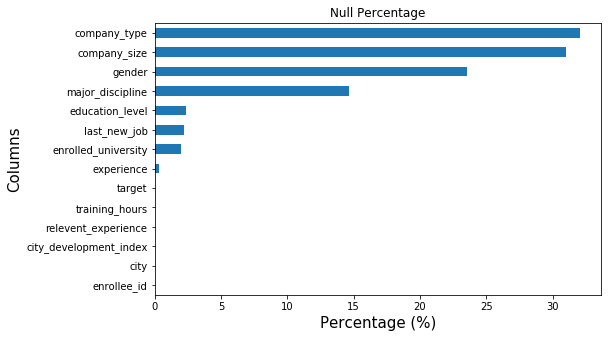

In [5]:
(df.isna().sum()/len(df)*100).sort_values(0).plot(kind='barh',figsize=(8,5),title='Null Percentage')
plt.ylabel('Columns',size=15)
plt.xlabel('Percentage (%)',size=15)

The top 4 columns consist medium to large number of null, while the bottom 4 considered to be small<br>

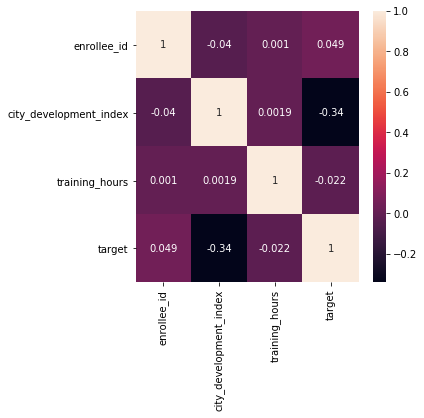

In [6]:
plt.figure(figsize=(5,5))
sns.heatmap(df.corr(),annot=True)

City development index show a sign of correlation to the target<br> 
And no other column with a sign of significant correlation

### Demograpic Analysis

In [7]:
def getUniqueCounts(columnName):
    tempDf = df[df[columnName].notna()]
    uniqueValue = np.unique(tempDf[columnName].astype(str).values)
    counts = list(map(lambda x: len(tempDf[tempDf[columnName]==x]),uniqueValue))
    return(uniqueValue,counts)

def countBar(columnName):
    return df[['target',columnName,'enrollee_id']].groupby([columnName,'target']).agg('count').plot(kind='barh',title=columnName.capitalize())

def getPercentageCounts(columnName):
    tempDf = df[df[columnName].notna()]
    uniqueValue, counts = getUniqueCounts(columnName)
    percentage = list(map(lambda x: x/len(tempDf)*100,counts))
    return pd.DataFrame({
        columnName:uniqueValue,
        'Counts':counts,
        'Percentage':percentage
    })

def percentagePlot(columnName):
    tempDf = df[df[columnName].notna()]
    uniqueValue, counts = getUniqueCounts(columnName)
    for index, value in enumerate(uniqueValue):
        (df[df[columnName]==value][['target',columnName,'enrollee_id']].groupby([columnName,'target']).agg('count')/counts[index]*100).plot(kind='barh')
        plt.xlabel('Percentage')
        plt.title(value.capitalize())

#### City and City Development Index

In [8]:
new=df[['city','city_development_index','enrollee_id']].groupby(['city','city_development_index']).agg('count').sort_values('enrollee_id',ascending=False)
new['Percentage']=new['enrollee_id']/len(df)*100
new[:5]

,,enrollee_id,Percentage
city,city_development_index,,
city_103,0.920,4355,22.732018
city_21,0.624,2702,14.103769
city_16,0.910,1533,8.001879
city_114,0.926,1336,6.973588
city_160,0.920,845,4.410690


Candidates mostly came from city that has high development index

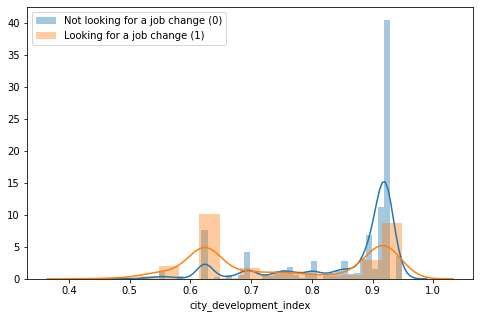

In [9]:
plt.figure(figsize=(8,5))
sns.distplot(df[df['target']==0]['city_development_index'],label='Not looking for a job change (0)')
sns.distplot(df[df['target']==1]['city_development_index'],label='Looking for a job change (1)')
plt.legend()

Candidate came from high city development index tends to be Not Looking for a job change<br>

#### Gender

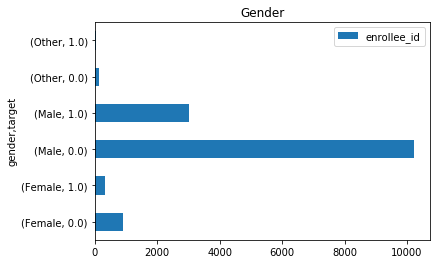

In [10]:
countBar('gender')

In [11]:
getPercentageCounts('gender')

,gender,Counts,Percentage
0,Female,1238,8.450512
1,Male,13221,90.245734
2,Other,191,1.303754


From the chart, we can see male is more likely to look for a job change, but the statement is irrelevant since Male is the majority candidates, so we cannot really get the conclusion which gender tends to look for a job change.

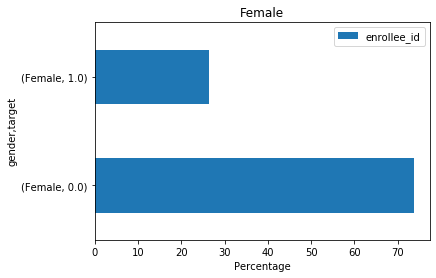

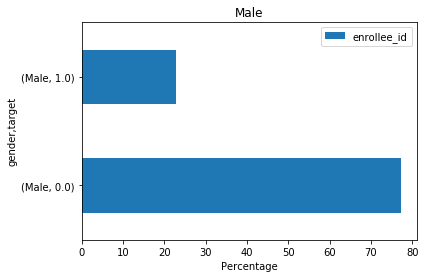

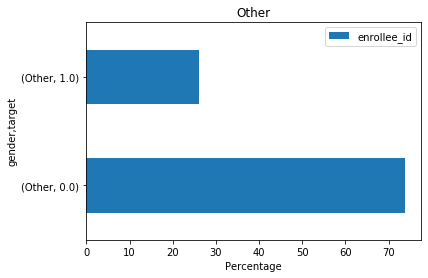

In [12]:
percentagePlot('gender')

Since we cannot get a conclusion from the numbers only, we might have an insight from the percentage rate, Here we see Female is slightly more to look for a job change than the Male (We purposely ignore the Other gender)

#### Education Level

In [13]:
getPercentageCounts('education_level')

,education_level,Counts,Percentage
0,Graduate,11598,62.028024
1,High School,2017,10.787250
2,Masters,4361,23.323350
3,Phd,414,2.214141
4,Primary School,308,1.647235


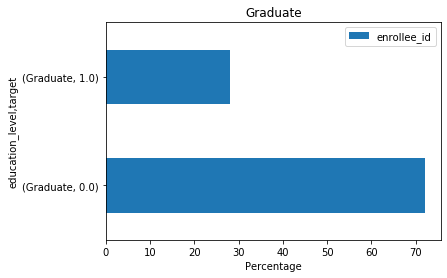

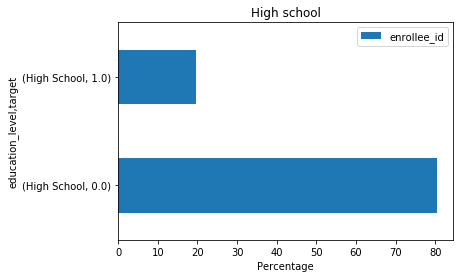

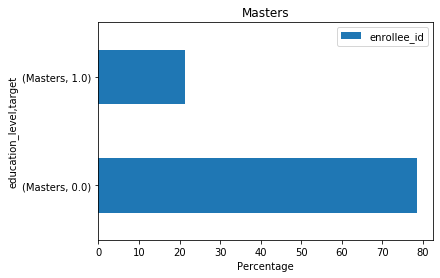

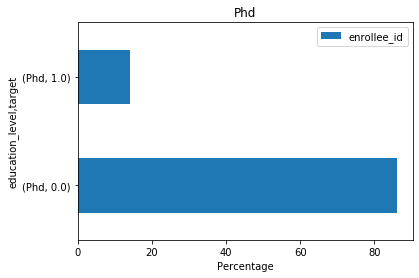

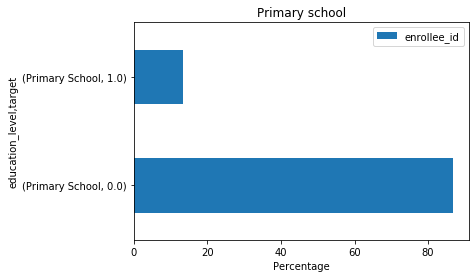

In [14]:
percentagePlot('education_level')

Candidates that have Graduate level of education are more likely to look for a job among other education level, but all education level dominated by candidates that is not looking for a job

#### Major Dicipline

In [15]:
getPercentageCounts('major_discipline')

,major_discipline,Counts,Percentage
0,Arts,253,1.547874
1,Business Degree,327,2.000612
2,Humanities,669,4.092995
3,No Major,223,1.364332
4,Other,381,2.330988
5,STEM,14492,88.663200


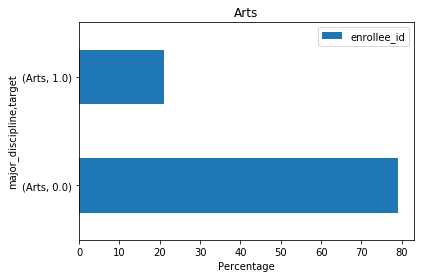

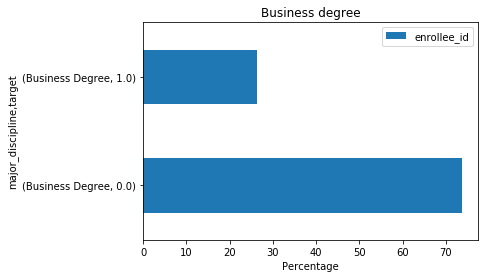

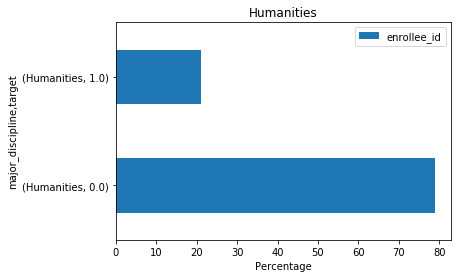

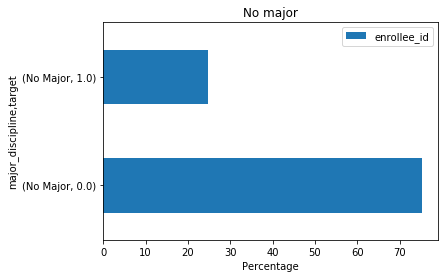

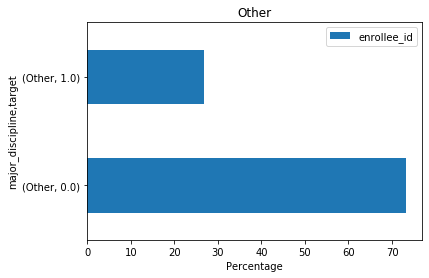

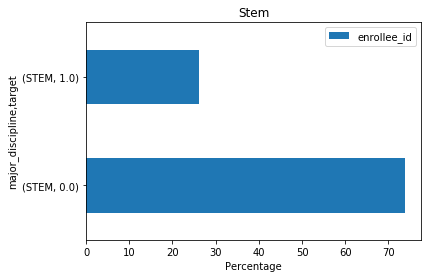

In [16]:
percentagePlot('major_discipline')

It seems that the ratio between candidates that look for a job and not look for a job is identical for each major dicipline